<a href="https://colab.research.google.com/github/victorluis22/metodos-numericos-otimizacao/blob/main/simplexNelderMeadipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

def restricao1(n):
  """Restrição de n >= 0"""
  penalidade = 10e12
  # n >= 1 => n - 1 >= 0 => -n + 1 <= 0

  return penalidade * (max([0, -n + 1.0])**2)

def restricao2(r):
  """Restrição de v <= vc"""
  vc = 20.0
  penalidade = 10e12
  g, m, kc = 9.8, 100.0, 0.42
  c = kc * 2 * np.pi * (r**2)
  z0 = 500

  def posicao (t):
    return z0 - ((g * m) / c)*t + ((g * (m**2)) / (c**2))*(1 - np.e**(-(c / m)*t))

  sol = root_scalar(posicao, method='bisect', bracket=[0.0, 10000])

  t = sol.root

  # print(t)
  velocidade = ((g * m) / c)*(1 - np.e**(-(c / m)*t)) - vc

  return penalidade * (max([0, velocidade])**2)

def custo(constantes, x):
  """Função que representa o custo para se fabricar os paraquedas."""
  [c0, c1, c2] = constantes
  [n, r] = x

  penalidade1 = restricao1(n)
  penalidade2 = restricao2(r)

  return n * (c0 + c1*(np.sqrt(2)*r) + c2*(2*np.pi*(r**2))**2) + penalidade1 + penalidade2


In [24]:
def plot3D(min, constantes, range=5):
    [c0, c1, c2] = constantes
    """Função que plota um gráfico 3D da superfície que representa a função custo."""
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.set_title(f'Função Custo do Paraquedas', fontsize=10)
    ax.set_xlabel("n")
    ax.set_ylabel("r")
    n = np.arange(-range, range, 0.15)
    r = np.arange(-range, range, 0.15)
    n, r = np.meshgrid(n, r)
    z = n * (c0 + c1*(np.sqrt(2)*r) + c2*(2*np.pi*(r**2))**2)

    ax.plot_surface(n, r, z, rstride=1, cstride=1, cmap='viridis')
    
    ax.scatter(min[0], min[1], min[0] * (c0 + c1*(np.sqrt(2)*min[1]) + c2*(2*np.pi*(min[1]**2))**2), color='red')

def plotContour(min, constantes, triangulos, range=5):
    """Função que plota as curvas de nível da superfície que representa a função custo."""
    [c0, c1, c2] = constantes
    fig = plt.figure()
    ax = fig.add_subplot()

    ax.set_title(f'Contorno Função Custo do Paraquedas', fontsize=10)
    ax.set_xlabel("n")
    ax.set_ylabel("r")
    n = np.arange(-range, range, 0.15)
    r = np.arange(-range, range, 0.15)
    n, r = np.meshgrid(n, r)
    z = n * (c0 + c1*(np.sqrt(2)*r) + c2*(2*np.pi*(r**2))**2)

    # Contorno da função
    ax.contour(n, r, z, colors='blue')

    # Triângulos formados
    for triangle in triangulos:
        x, y = [], []
        for point in triangle:
            ax.scatter(point[0], point[1], color='green', label=f'Mínimo')
            x.append(point[0])
            y.append(point[1])
            ax.fill(x, y, facecolor='none', edgecolor='purple')

    # Ponto de mínimo encontrado
    ax.scatter(min[0], min[1], color='red')

    plt.show()

======== Resultado Simplex Nelder Mead

Conjunto 1:
[[3.74540119 9.50714306]
 [7.31993942 5.98658484]
 [1.5601864  1.5599452 ]]
 Mínimo=[1.         4.30906533]
Conjunto 2:
[[0.58083612 8.66176146]
 [6.01115012 7.08072578]
 [0.20584494 9.69909852]]
 Mínimo=[1.         4.30906533]
Conjunto 3:
[[8.32442641 2.12339111]
 [1.81824967 1.8340451 ]
 [3.04242243 5.24756432]]
 Mínimo=[1.         4.30906533]
Conjunto 4:
[[4.31945019 2.9122914 ]
 [6.11852895 1.39493861]
 [2.92144649 3.66361843]]
 Mínimo=[1.         4.30906533]
Conjunto 5:
[[4.56069984 7.85175961]
 [1.99673782 5.14234438]
 [5.92414569 0.46450413]]
 Mínimo=[1.         4.30906533]
Conjunto 6:
[[6.07544852 1.70524124]
 [0.65051593 9.48885537]
 [9.65632033 8.08397348]]
 Mínimo=[1.         4.30906533]
Conjunto 7:
[[3.04613769 0.97672114]
 [6.84233027 4.40152494]
 [1.22038235 4.9517691 ]]
 Mínimo=[1.         4.30906533]
Conjunto 8:
[[0.34388521 9.09320402]
 [2.58779982 6.62522284]
 [3.11711076 5.20068021]]
 Mínimo=[1.         4.32470023]


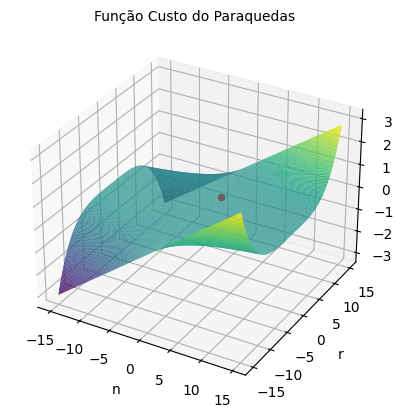

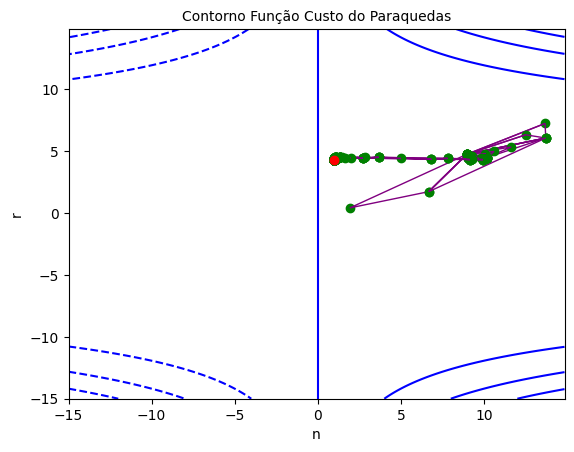

In [25]:
def nelderMeadSimplex (constantes, x, y, z, dimensao):
  e = 1e-6
  time = 0
  timeout = 1000
  triangulos = []
  pontos = np.copy([x, y, z])

  # Constantes para contração interna, externa, reflexão, expansão, etc
  c, ic, p, oc, r, ex = -1.0, -0.5, 0.0, 0.5, 1.0, 2.0

  while time < timeout:
    triangulos.append(np.copy(pontos))
    vertices = [custo(constantes, pontos[0]), custo(constantes, pontos[1]), custo(constantes, pontos[2])]
    
    # Ordenação dos pontos
    melhorIndice = vertices.index(np.amin(vertices))
    piorIndice = vertices.index(np.amax(vertices))
    indiceNeutro = [i for i in range(len(vertices)) if i != melhorIndice and i != piorIndice][0]

    # print(f'\nIteração {time}==========================')
    # print(f'Pontos: {pontos}')
    # print(f'f(x) dos vertices: {vertices}')
    # print(f'Melhor vertice: vertices[{melhorIndice}] = {vertices[melhorIndice]}')
    # print(f'Vertice Neutro: vertices[{indiceNeutro}] = {vertices[indiceNeutro]}')
    # print(f'Pior vertice: vertices[{piorIndice}] = {vertices[piorIndice]}')

    # Cálculo do Centroide
    centroide = np.array([0.0,0.0])
    for i, ponto in enumerate(pontos):
      if i != piorIndice:
        centroide += ponto

    centroide = centroide / dimensao

    # print (f'Centroide: {centroide}')

    # Condição de parada
    if vertices[piorIndice] - vertices[melhorIndice] < e:
      break

    xr = ((1.0 + r) * centroide) - (r * pontos[piorIndice])
    fr = custo(constantes, xr)

    # Reflexão
    if vertices[melhorIndice] <= fr and fr < vertices[indiceNeutro]:
      # print(f'Reflexão: {xr}')
      pontos[piorIndice] = xr
    # Expansão
    elif fr < vertices[melhorIndice]:
      # print(f'Expansão')
      xex = ((1.0 + ex) * centroide) - (ex * pontos[piorIndice])
      fex = custo(constantes, xex)

      if fex < fr:
        pontos[piorIndice] = xex
      else:
        pontos[piorIndice] = xr
    # Contração Externa
    elif vertices[indiceNeutro] <= fr and fr < vertices[piorIndice]:
      # print(f'Contração Externa')
      xoc = ((1.0 + oc) * centroide) - (oc * pontos[piorIndice])
      foc = custo(constantes, xoc)

      if foc < fr:
        pontos[piorIndice] = xoc
      else:
        # Redução
        pontos[indiceNeutro] = (pontos[melhorIndice] - (pontos[indiceNeutro] - pontos[melhorIndice])) / 2.0
        pontos[piorIndice] = (pontos[melhorIndice] - (pontos[piorIndice] - pontos[melhorIndice])) / 2.0
    # Contração Interna
    elif fr >= vertices[piorIndice]:
      # print(f'Contração Interna')
      xic = ((1.0 + ic) * centroide) - (ic * pontos[piorIndice])
      fic = custo(constantes, xic)

      if fic < fr:
        pontos[piorIndice] = xic
      else:
        # Redução
        pontos[indiceNeutro] = (pontos[melhorIndice] - (pontos[indiceNeutro] - pontos[melhorIndice])) / 2.0
        pontos[piorIndice] = (pontos[melhorIndice] - (pontos[piorIndice] - pontos[melhorIndice])) / 2.0

    time += 1

  return [pontos[melhorIndice], triangulos]

# Define a semente fixa para reprodutibilidade
semente = 42
np.random.seed(semente)

# Gera 100 conjuntos de três pontos com duas coordenadas aleatórias
conjuntos = 100
pontosPorConjunto = 3
coordenadasPorPonto = 2

# Cria um array tridimensional para armazenar os conjuntos de pontos
pontos = np.random.uniform(0, 10, (conjuntos, pontosPorConjunto, coordenadasPorPonto))

minimos = []
triangulos = []
constantes = [1.0, 2.0, 1.0]

print(f'======== Resultado Simplex Nelder Mead\n')
# Exibe os conjuntos gerados
for i, ponto in enumerate(pontos, start=1):
  [min, triangulos] = nelderMeadSimplex(constantes, ponto[0], ponto[1], ponto[2], 2.0)
  print(f"Conjunto {i}:\n{ponto}\n Mínimo={min}")
  minimos.append(min)

minimos = np.array(minimos)
media = np.array([np.mean(minimos[:, 0]), np.mean(minimos[:, 1])])
desvioPadrao = np.array([np.std(minimos[:, 0]), np.std(minimos[:, 1])])
 
print(f'\nMédia dos valores: {media}')
print(f'Desvio Padrão dos valores: {desvioPadrao}')

plot3D(min, constantes, 15.0)
plotContour(min, constantes, triangulos, 15.0)